# 2段階のNLモデルの構築
上位：私事トリップ選択モデル（しないor義務or裁量）  
下位：端末選択モデル
### 5との違い
- ネストパラメータの導入方法が異なる

In [1]:
# ライブラリの導入
# ライブラリの導入
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Noto Sans CJK JP"  # 日本語入力対応
import time

import biogeme.biogeme_logging as blog

from biogeme.database import Database
from biogeme.expressions import Variable, Beta
from biogeme.biogeme import BIOGEME
from biogeme.models import lognested
from biogeme.models import nested
from biogeme.nests import OneNestForNestedLogit, NestsForNestedLogit
from biogeme.results_processing import get_pandas_estimated_parameters

/home/shibumtk/B4research/estimate/.venv/lib/python3.12/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# 入力データの読み込み
master_df = pd.read_csv("/home/shibumtk/B4research/estimate/data/NL_data/c_NL_Logit_master2.csv", encoding="utf-8-sig")
master_df = master_df.fillna(0) # 欠損値を一応埋める

# 文字列は除外する
drop_cols =['NearestStation', 'WorkplaceStation']
master_df = master_df.drop(columns=drop_cols)

# 確認
print(len(master_df))
master_df.columns

46738


Index(['Personal_ID', 'HouseholdIncome', 'sex', 'age', 'JobType',
       'ComuTime[m]', 'MainlineTime[m]', 'AccessTime_used[m]', 'HouseholdType',
       'HouseholdMembers(all)', 'YoungestMember_No', 'WorkTime[m]',
       'AfterTime_work[m]', 'AfterTime_home[m]', 'first_transportation',
       'NearestStation_code', 'near_chuko_area300', 'near_chuko_area1000',
       'near_300index1', 'near_1000index1', 'near_300index2',
       'near_1000index2', 'WorkplaceStation_code', 'WP_chuko_area300',
       'WP_chuko_area1000', 'WP_300index1', 'WP_1000index1', 'WP_300index2',
       'WP_1000index2', 'PriTrip', 'timing', 'FacilityType', 'TripPurpose',
       'PriTrip_class', 'StayTime', 'walk_av', 'walk_time[m]', 'bicycle_av',
       'bicycle_time[m]', 'bicycle_parking_fee', 'bus_av', 'bus_time[m]',
       'bus_cost', 'dist_nearest_BusStop[km]', 'car_av', 'car_time[m]',
       'car_cost'],
      dtype='object')

In [3]:
# NL用のCHOICEカラムを作成
mode_map = {1:0, 2:1, 4:2, 5:3} # 端末手段を0~3にまとめる
# 端末手段のカラムを書き換え（新しいカラムを作成）
master_df["t_first_transportation"] = master_df["first_transportation"].map(mode_map)

df = master_df.copy()
# CHOICEカラム
df['CHOICE9'] = np.select(
    [df['PriTrip_class'] == 0, df['PriTrip_class'] == 1, df['PriTrip_class'] == 2],
    [1, 2 + df['t_first_transportation'], 6 + df['t_first_transportation']]
).astype("int64")

t_master_df = df.copy()

# 確認
print(t_master_df['CHOICE9'].value_counts().sort_index().sum())
t_master_df['CHOICE9'].value_counts().sort_index()

46738


CHOICE9
1    38142
2     2954
3      438
4      299
5       64
6     3912
7      420
8      417
9       92
Name: count, dtype: int64

In [4]:
# 世帯構成ごとにデータリストを抽出
solo_df = t_master_df[t_master_df["HouseholdType"] == 1]
couple_df = t_master_df[t_master_df["HouseholdType"] == 2]
SG_df = t_master_df[t_master_df["HouseholdType"] == 3] # SG = second generation（2世代）

# 確認
print("単身世帯", len(solo_df))
print("夫婦世帯", len(couple_df))
print("二世代世帯", len(SG_df))

単身世帯 11180
夫婦世帯 9600
二世代世帯 24692


In [5]:
# biogemeデータリストに格納する
master_db = Database("solo_PTdata", solo_df)

In [6]:
# ==============
# 変数定義
# ==============
CHOICE = Variable("CHOICE9")

# availability & time
WA_AV = Variable("walk_av")
WA_TT = Variable("walk_time[m]")

BI_AV = Variable("bicycle_av")
BI_TT = Variable("bicycle_time[m]")

BU_AV = Variable("bus_av")
BU_TT = Variable("bus_time[m]")

CA_AV = Variable("car_av")
CA_TT = Variable("car_time[m]")

# Trip-level covariates
WORKTIME    = Variable("WorkTime[m]")
AF_WORKTIME = Variable("AfterTime_work[m]") # AF=after
MACMTIME    = Variable("MainlineTime[m]")
HHM_all     = Variable("HouseholdMembers(all)")
NEKI_INDEX  = Variable("near_1000index2")
WEKI_INDEX  = Variable("WP_1000index2") # 就業地駅土地利用指標

# scaled
WORKTIME_SCALED    = master_db.define_variable("WORKTIME_SCALED", WORKTIME / 60)
AF_WORKTIME_SCALED = master_db.define_variable("AF_WORKTIME_SCALED", AF_WORKTIME / 60)
MACMTIME_SCALED    = master_db.define_variable("MACMTIME_SCALED", MACMTIME / 60)
NEKI_SCALED        = master_db.define_variable("NEKI_SCALED", NEKI_INDEX / 1_000_000)
WEKI_SCALED        = master_db.define_variable("WEKI_SCALED", WEKI_INDEX / 1_000_000)

# ==============
# パラメータ
# ==============
# モード側ASC（walk基準）
ASC_BI = Beta("ASC_BI", 0, None, None, 0)
ASC_BU = Beta("ASC_BU", 0, None, None, 0)
ASC_CA = Beta("ASC_CA", 0, None, None, 0)

# 端末時間係数（共通変数）
b_at = Beta("b_at", 0, None, None, 0)

# Trip-type（Duty/Disc）側
ASC_DU = Beta("ASC_DU", 0, None, None, 0)
ASC_DI = Beta("ASC_DI", 0, None, None, 0)

# 独立に導入する説明変数
b_work_du        = Beta("b_work_du", 0, None, None, 0)
b_macmtime_du    = Beta("b_macmtime_du", 0, None, None, 0)
b_n_eki_du       = Beta("b_n_eki_du", 0, None, None, 0)
b_w_eki_du       = Beta("b_w_eki_du", 0, None, None, 0)
b_hhm_du         = Beta("b_hhm_du", 0, None, None, 0)

b_work_di        = Beta("b_work_di", 0, None, None, 0)
b_macmtime_di    = Beta("b_macmtime_di", 0, None, None, 0)
b_n_eki_di       = Beta("b_n_eki_di", 0, None, None, 0)
b_w_eki_di       = Beta("b_w_eki_di", 0, None, None, 0)
b_hhm_di         = Beta("b_hhm_di", 0, None, None, 0)

# 共通変数
b_aftime_work = Beta("b_aftime_work", 0, None, None, 0)

# ネストパラメータ（NoTripは単一代替なので固定=1）
# NoTripは単一代替なら μ を置いても効かないので固定でOK
MU_NO = Beta("MU_NO", 1.0, 1.0, 1.0, 1)

# λを推定
LAMBDA_DU = Beta("LAMBDA_DU", 0.8, 0.01, 1.0, 0)  # (0,1]に制約
LAMBDA_DI = Beta("LAMBDA_DI", 0.8, 0.01, 1.0, 0)  # (0,1]に制約
MU_DU = 1 / LAMBDA_DU
MU_DI = 1 / LAMBDA_DI

# ==============
# 代替ID（9択）
# ==============
NO      = 1
DU_WA   = 2
DU_BI   = 3
DU_BU   = 4
DU_CA   = 5
DI_WA   = 6
DI_BI   = 7
DI_BU   = 8
DI_CA   = 9

# ==============
# 効用
# NoTripは基準：0
# ==============
V_NO = 0

# Trip-type utility（Duty/Disc）
V_DU_PRI = (ASC_DU
            + b_aftime_work * AF_WORKTIME_SCALED
            + b_macmtime_du * MACMTIME_SCALED
            + b_n_eki_du    * NEKI_SCALED)

V_DI_PRI = (ASC_DI
            + b_aftime_work * AF_WORKTIME_SCALED
            + b_macmtime_di * MACMTIME_SCALED
            + b_n_eki_di    * NEKI_SCALED)

# Mode utility（walk基準でASC=0）
V_WA_MODE = b_at * WA_TT
V_BI_MODE = ASC_BI + b_at * BI_TT
V_BU_MODE = ASC_BU + b_at * BU_TT
V_CA_MODE = ASC_CA + b_at * CA_TT

# 9 alternatives utilities
V = {
    NO:    V_NO,

    DU_WA: V_DU_PRI + V_WA_MODE,
    DU_BI: V_DU_PRI + V_BI_MODE,
    DU_BU: V_DU_PRI + V_BU_MODE,
    DU_CA: V_DU_PRI + V_CA_MODE,

    DI_WA: V_DI_PRI + V_WA_MODE,
    DI_BI: V_DI_PRI + V_BI_MODE,
    DI_BU: V_DI_PRI + V_BU_MODE,
    DI_CA: V_DI_PRI + V_CA_MODE
}

# availability（NoTripは常に利用可能=1）
av = {
    NO: 1,

    DU_WA: WA_AV,
    DU_BI: BI_AV,
    DU_BU: BU_AV,
    DU_CA: CA_AV,

    DI_WA: WA_AV,
    DI_BI: BI_AV,
    DI_BU: BU_AV,
    DI_CA: CA_AV,
}

# ==============
# nests（上位＝{NoTrip, Duty, Discretion}）
# ==============
nest_no = OneNestForNestedLogit(MU_NO, [NO], name="NoTrip")
nest_du = OneNestForNestedLogit(MU_DU, [DU_WA, DU_BI, DU_BU, DU_CA], name="Duty")
nest_di = OneNestForNestedLogit(MU_DI, [DI_WA, DI_BI, DI_BU, DI_CA], name="Discretion")

nests = NestsForNestedLogit(
    choice_set=list(V.keys()),
    tuple_of_nests=(nest_no, nest_du, nest_di)
)

In [7]:
# loglikelihood
logprob = lognested(V, av, nests, CHOICE)

# estimate
logger = blog.get_screen_logger(level=blog.INFO)
biogeme = BIOGEME(
    master_db,
    logprob,
    generate_html=False,
    generate_yaml=False,
    optimization_algorithm="simple_bounds_BFGS",
    calculating_second_derivatives="never", 
    save_iterations=False
)
biogeme.model_name = "NL_NoTrip0_DutyDisc_Mode2_solo"

biogeme.calculate_null_loglikelihood(av)
solo_results = biogeme.estimate()
print("estimate() returned") 
print(solo_results.short_summary())

# パラメータ推定値をpandasに格納して表示
pandas_solo_results = get_pandas_estimated_parameters(estimation_results=solo_results)
print(pandas_solo_results.to_string)

Biogeme parameters read from biogeme.toml. 
Starting values for the algorithm: {} 
Optimization algorithm: BFGS with simple bounds [simple_bounds_BFGS]. 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: BFGS with trust region for simple bounds 
E0120 22:04:32.623783   46390 slow_operation_alarm.cc:73] 
********************************
[Compiling module jit_sum_function for CPU] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
E0120 22:07:23.192821   46321 slow_operation_alarm.cc:140] The operation took 4m50.575598751s

********************************
[Compiling module jit_sum_function for CPU] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Iter.          ASC_DU   b_aftime_work   b_macmtime_du      b_n_eki_du            b_at       LAMB

estimate() returned
Results for model NL_NoTrip0_DutyDisc_Mode2_solo
Nbr of parameters:		13
Sample size:			11180
Excluded data:			0
Null log likelihood:		-16526.16
Final log likelihood:		-9192.536
Likelihood ratio test (null):		14667.26
Rho square (null):			0.444
Rho bar square (null):			0.443
Akaike Information Criterion:	18411.07
Bayesian Information Criterion:	18506.26

<bound method DataFrame.to_string of              Name     Value  BHHH std err.  BHHH t-stat.  BHHH p-value
0          ASC_DU -4.715517       0.171407    -27.510592  0.000000e+00
1   b_aftime_work  0.400096       0.016576     24.137460  0.000000e+00
2   b_macmtime_du -0.477140       0.089979     -5.302767  1.140606e-07
3      b_n_eki_du  0.052450       0.073510      0.713518  4.755253e-01
4            b_at -0.017070       0.003831     -4.455812  8.357610e-06
5       LAMBDA_DU  0.045534       0.011159      4.080407  4.495682e-05
6          ASC_BI -0.184171       0.041762     -4.409964  1.033877e-05
7          ASC_BU -

In [8]:
pandas_solo_results.to_csv("/home/shibumtk/B4research/estimate/data/results/NL_2nest_estimated_parameters6_solo.csv", index=False, encoding="utf-8-sig")
print("saved: estimated_parameters6_solo.csv")

saved: estimated_parameters6_solo.csv


In [9]:
# biogemeデータリストに格納する
master_db = Database("couple_PTdata", couple_df)

In [10]:
# ==============
# 変数定義
# ==============
CHOICE = Variable("CHOICE9")

# availability & time
WA_AV = Variable("walk_av")
WA_TT = Variable("walk_time[m]")

BI_AV = Variable("bicycle_av")
BI_TT = Variable("bicycle_time[m]")

BU_AV = Variable("bus_av")
BU_TT = Variable("bus_time[m]")

CA_AV = Variable("car_av")
CA_TT = Variable("car_time[m]")

# Trip-level covariates
WORKTIME    = Variable("WorkTime[m]")
AF_WORKTIME = Variable("AfterTime_work[m]") # AF=after
MACMTIME    = Variable("MainlineTime[m]")
HHM_all     = Variable("HouseholdMembers(all)")
NEKI_INDEX  = Variable("near_1000index2")
WEKI_INDEX  = Variable("WP_1000index2") # 就業地駅土地利用指標

# scaled
WORKTIME_SCALED    = master_db.define_variable("WORKTIME_SCALED", WORKTIME / 60)
AF_WORKTIME_SCALED = master_db.define_variable("AF_WORKTIME_SCALED", AF_WORKTIME / 60)
MACMTIME_SCALED    = master_db.define_variable("MACMTIME_SCALED", MACMTIME / 60)
NEKI_SCALED        = master_db.define_variable("NEKI_SCALED", NEKI_INDEX / 1_000_000)
WEKI_SCALED        = master_db.define_variable("WEKI_SCALED", WEKI_INDEX / 1_000_000)

# ==============
# パラメータ
# ==============
# モード側ASC（walk基準）
ASC_BI = Beta("ASC_BI", 0, None, None, 0)
ASC_BU = Beta("ASC_BU", 0, None, None, 0)
ASC_CA = Beta("ASC_CA", 0, None, None, 0)

# 端末時間係数（共通変数）
b_at = Beta("b_at", 0, None, None, 0)

# Trip-type（Duty/Disc）側
ASC_DU = Beta("ASC_DU", 0, None, None, 0)
ASC_DI = Beta("ASC_DI", 0, None, None, 0)

# 独立に導入する説明変数
b_work_du        = Beta("b_work_du", 0, None, None, 0)
b_macmtime_du    = Beta("b_macmtime_du", 0, None, None, 0)
b_n_eki_du       = Beta("b_n_eki_du", 0, None, None, 0)
b_w_eki_du       = Beta("b_w_eki_du", 0, None, None, 0)
b_hhm_du         = Beta("b_hhm_du", 0, None, None, 0)

b_work_di        = Beta("b_work_di", 0, None, None, 0)
b_macmtime_di    = Beta("b_macmtime_di", 0, None, None, 0)
b_n_eki_di       = Beta("b_n_eki_di", 0, None, None, 0)
b_w_eki_di       = Beta("b_w_eki_di", 0, None, None, 0)
b_hhm_di         = Beta("b_hhm_di", 0, None, None, 0)

# 共通変数
b_aftime_work = Beta("b_aftime_work", 0, None, None, 0)

# ネストパラメータ（NoTripは単一代替なので固定=1）
# NoTripは単一代替なら μ を置いても効かないので固定でOK
MU_NO = Beta("MU_NO", 1.0, 1.0, 1.0, 1)

# λを推定
LAMBDA_DU = Beta("LAMBDA_DU", 0.8, 0.01, 1.0, 0)  # (0,1]に制約
LAMBDA_DI = Beta("LAMBDA_DI", 0.8, 0.01, 1.0, 0)  # (0,1]に制約
MU_DU = 1 / LAMBDA_DU
MU_DI = 1 / LAMBDA_DI

# ==============
# 代替ID（9択）
# ==============
NO      = 1
DU_WA   = 2
DU_BI   = 3
DU_BU   = 4
DU_CA   = 5
DI_WA   = 6
DI_BI   = 7
DI_BU   = 8
DI_CA   = 9

# ==============
# 効用
# NoTripは基準：0
# ==============
V_NO = 0

# Trip-type utility（Duty/Disc）
V_DU_PRI = (ASC_DU
            + b_aftime_work * AF_WORKTIME_SCALED
            + b_macmtime_du * MACMTIME_SCALED
            + b_n_eki_du    * NEKI_SCALED)

V_DI_PRI = (ASC_DI
            + b_aftime_work * AF_WORKTIME_SCALED
            + b_macmtime_di * MACMTIME_SCALED
            + b_n_eki_di    * NEKI_SCALED)

# Mode utility（walk基準でASC=0）
V_WA_MODE = b_at * WA_TT
V_BI_MODE = ASC_BI + b_at * BI_TT
V_BU_MODE = ASC_BU + b_at * BU_TT
V_CA_MODE = ASC_CA + b_at * CA_TT

# 9 alternatives utilities
V = {
    NO:    V_NO,

    DU_WA: V_DU_PRI + V_WA_MODE,
    DU_BI: V_DU_PRI + V_BI_MODE,
    DU_BU: V_DU_PRI + V_BU_MODE,
    DU_CA: V_DU_PRI + V_CA_MODE,

    DI_WA: V_DI_PRI + V_WA_MODE,
    DI_BI: V_DI_PRI + V_BI_MODE,
    DI_BU: V_DI_PRI + V_BU_MODE,
    DI_CA: V_DI_PRI + V_CA_MODE
}

# availability（NoTripは常に利用可能=1）
av = {
    NO: 1,

    DU_WA: WA_AV,
    DU_BI: BI_AV,
    DU_BU: BU_AV,
    DU_CA: CA_AV,

    DI_WA: WA_AV,
    DI_BI: BI_AV,
    DI_BU: BU_AV,
    DI_CA: CA_AV,
}

# ==============
# nests（上位＝{NoTrip, Duty, Discretion}）
# ==============
nest_no = OneNestForNestedLogit(MU_NO, [NO], name="NoTrip")
nest_du = OneNestForNestedLogit(MU_DU, [DU_WA, DU_BI, DU_BU, DU_CA], name="Duty")
nest_di = OneNestForNestedLogit(MU_DI, [DI_WA, DI_BI, DI_BU, DI_CA], name="Discretion")

nests = NestsForNestedLogit(
    choice_set=list(V.keys()),
    tuple_of_nests=(nest_no, nest_du, nest_di)
)

In [11]:
# loglikelihood
logprob = lognested(V, av, nests, CHOICE)

# estimate
logger = blog.get_screen_logger(level=blog.INFO)
biogeme = BIOGEME(
    master_db,
    logprob,
    generate_html=False,
    generate_yaml=False,
    optimization_algorithm="simple_bounds_BFGS",
    calculating_second_derivatives="never", 
    save_iterations=False
)
biogeme.model_name = "NL_NoTrip0_DutyDisc_Mode2_couple"

biogeme.calculate_null_loglikelihood(av)
couple_results = biogeme.estimate()
print("estimate() returned") 
print(couple_results.short_summary())

# パラメータ推定値をpandasに格納して表示
pandas_couple_results = get_pandas_estimated_parameters(estimation_results=couple_results)
print(pandas_couple_results.to_string)

Biogeme parameters read from biogeme.toml. 
Biogeme parameters read from biogeme.toml. 
Starting values for the algorithm: {} 
Starting values for the algorithm: {} 
Optimization algorithm: BFGS with simple bounds [simple_bounds_BFGS]. 
Optimization algorithm: BFGS with simple bounds [simple_bounds_BFGS]. 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: BFGS with trust region for simple bounds 
** Optimization: BFGS with trust region for simple bounds 
Iter.          ASC_DU   b_aftime_work   b_macmtime_du      b_n_eki_du            b_at       LAMBDA_DU          ASC_BI          ASC_BU          ASC_CA          ASC_DI   b_macmtime_di      b_n_eki_di       LAMBDA_DI     Function    Relgrad   Radius      Rho      
Iter.          ASC_DU   b_aftime_work   b_macmtime_du      b_n_eki_du            b_at       LAMBDA_DU          ASC_BI          ASC_BU          ASC_CA     

estimate() returned
Results for model NL_NoTrip0_DutyDisc_Mode2_couple
Nbr of parameters:		13
Sample size:			9600
Excluded data:			0
Null log likelihood:		-16843.26
Final log likelihood:		-5642.641
Likelihood ratio test (null):		22401.24
Rho square (null):			0.665
Rho bar square (null):			0.664
Akaike Information Criterion:	11311.28
Bayesian Information Criterion:	11404.49

<bound method DataFrame.to_string of              Name     Value  BHHH std err.  BHHH t-stat.  BHHH p-value
0          ASC_DU -6.439496       0.239452    -26.892684  0.000000e+00
1   b_aftime_work  0.513034       0.021920     23.404978  0.000000e+00
2   b_macmtime_du -0.640634       0.123843     -5.172936  2.304436e-07
3      b_n_eki_du  0.241620       0.106507      2.268590  2.329327e-02
4            b_at -0.023084       0.004478     -5.154896  2.537723e-07
5       LAMBDA_DU  0.074280       0.016534      4.492403  7.042406e-06
6          ASC_BI -0.286480       0.056827     -5.041296  4.623900e-07
7          ASC_BU 

In [12]:
pandas_couple_results.to_csv("/home/shibumtk/B4research/estimate/data/results/NL_2nest_estimated_parameters6_couple.csv", index=False, encoding="utf-8-sig")
print("saved: estimated_parameters6_couple.csv")

saved: estimated_parameters6_couple.csv


In [13]:
# 子供の人数ダミーを作成
# 子供二人以上で1が入力される（世帯人数としては4人以上のはず）
SG_df['child_over2'] = np.where(SG_df['HouseholdMembers(all)'] >= 4, 1, 0) 
SG_df['child_over2'].value_counts().sort_index()

/tmp/ipykernel_46321/1811513184.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SG_df['child_over2'] = np.where(SG_df['HouseholdMembers(all)'] >= 4, 1, 0)


child_over2
0    13659
1    11033
Name: count, dtype: int64

In [14]:
# biogemeデータリストに格納する
master_db = Database("SG_PTdata", SG_df)

In [15]:
# ==============
# 変数定義
# ==============
CHOICE = Variable("CHOICE9")

# availability & time
WA_AV = Variable("walk_av")
WA_TT = Variable("walk_time[m]")

BI_AV = Variable("bicycle_av")
BI_TT = Variable("bicycle_time[m]")

BU_AV = Variable("bus_av")
BU_TT = Variable("bus_time[m]")

CA_AV = Variable("car_av")
CA_TT = Variable("car_time[m]")

# Trip-level covariates
WORKTIME    = Variable("WorkTime[m]")
AF_WORKTIME = Variable("AfterTime_work[m]") # AF=after
MACMTIME    = Variable("MainlineTime[m]")
HHM_all     = Variable("HouseholdMembers(all)")
child_over2 = Variable("child_over2") # 子供二人以上ダミー
NEKI_INDEX  = Variable("near_1000index2")
WEKI_INDEX  = Variable("WP_1000index2") # 就業地駅土地利用指標

# scaled
WORKTIME_SCALED    = master_db.define_variable("WORKTIME_SCALED", WORKTIME / 60)
AF_WORKTIME_SCALED = master_db.define_variable("AF_WORKTIME_SCALED", AF_WORKTIME / 60)
MACMTIME_SCALED    = master_db.define_variable("MACMTIME_SCALED", MACMTIME / 60)
NEKI_SCALED        = master_db.define_variable("NEKI_SCALED", NEKI_INDEX / 1_000_000)
WEKI_SCALED        = master_db.define_variable("WEKI_SCALED", WEKI_INDEX / 1_000_000)

# ==============
# パラメータ
# ==============
# モード側ASC（walk基準）
ASC_BI = Beta("ASC_BI", 0, None, None, 0)
ASC_BU = Beta("ASC_BU", 0, None, None, 0)
ASC_CA = Beta("ASC_CA", 0, None, None, 0)

# 端末時間係数（共通変数）
b_at = Beta("b_at", 0, None, None, 0)

# Trip-type（Duty/Disc）側
ASC_DU = Beta("ASC_DU", 0, None, None, 0)
ASC_DI = Beta("ASC_DI", 0, None, None, 0)

# 独立に導入する説明変数
b_work_du        = Beta("b_work_du", 0, None, None, 0)
b_macmtime_du    = Beta("b_macmtime_du", 0, None, None, 0)
b_n_eki_du       = Beta("b_n_eki_du", 0, None, None, 0)
b_w_eki_du       = Beta("b_w_eki_du", 0, None, None, 0)
b_hhm_du         = Beta("b_hhm_du", 0, None, None, 0)
b_child2_du      = Beta("b_child2_du", 0, None, None, 0)

b_work_di        = Beta("b_work_di", 0, None, None, 0)
b_macmtime_di    = Beta("b_macmtime_di", 0, None, None, 0)
b_n_eki_di       = Beta("b_n_eki_di", 0, None, None, 0)
b_w_eki_di       = Beta("b_w_eki_di", 0, None, None, 0)
b_hhm_di         = Beta("b_hhm_di", 0, None, None, 0)
b_child2_di      = Beta("b_child2_di", 0, None, None, 0)

# 共通変数
b_aftime_work = Beta("b_aftime_work", 0, None, None, 0)

# ネストパラメータ（NoTripは単一代替なので固定=1）
# NoTripは単一代替なら μ を置いても効かないので固定でOK
MU_NO = Beta("MU_NO", 1.0, 1.0, 1.0, 1)

# λを推定
LAMBDA_DU = Beta("LAMBDA_DU", 0.8, 0.01, 1.0, 0)  # (0,1]に制約
LAMBDA_DI = Beta("LAMBDA_DI", 0.8, 0.01, 1.0, 0)  # (0,1]に制約
MU_DU = 1 / LAMBDA_DU
MU_DI = 1 / LAMBDA_DI

# ==============
# 代替ID（9択）
# ==============
NO      = 1
DU_WA   = 2
DU_BI   = 3
DU_BU   = 4
DU_CA   = 5
DI_WA   = 6
DI_BI   = 7
DI_BU   = 8
DI_CA   = 9

# ==============
# 効用
# NoTripは基準：0
# ==============
V_NO = 0

# Trip-type utility（Duty/Disc）
V_DU_PRI = (ASC_DU
            + b_aftime_work * AF_WORKTIME_SCALED
            + b_macmtime_du * MACMTIME_SCALED
            + b_n_eki_du    * NEKI_SCALED
            + b_child2_du   * child_over2)

V_DI_PRI = (ASC_DI
            + b_aftime_work * AF_WORKTIME_SCALED
            + b_macmtime_di * MACMTIME_SCALED
            + b_n_eki_di    * NEKI_SCALED
            + b_child2_di   * child_over2)

# Mode utility（walk基準でASC=0）
V_WA_MODE = b_at * WA_TT
V_BI_MODE = ASC_BI + b_at * BI_TT
V_BU_MODE = ASC_BU + b_at * BU_TT
V_CA_MODE = ASC_CA + b_at * CA_TT

# 9 alternatives utilities
V = {
    NO:    V_NO,

    DU_WA: V_DU_PRI + V_WA_MODE,
    DU_BI: V_DU_PRI + V_BI_MODE,
    DU_BU: V_DU_PRI + V_BU_MODE,
    DU_CA: V_DU_PRI + V_CA_MODE,

    DI_WA: V_DI_PRI + V_WA_MODE,
    DI_BI: V_DI_PRI + V_BI_MODE,
    DI_BU: V_DI_PRI + V_BU_MODE,
    DI_CA: V_DI_PRI + V_CA_MODE
}

# availability（NoTripは常に利用可能=1）
av = {
    NO: 1,

    DU_WA: WA_AV,
    DU_BI: BI_AV,
    DU_BU: BU_AV,
    DU_CA: CA_AV,

    DI_WA: WA_AV,
    DI_BI: BI_AV,
    DI_BU: BU_AV,
    DI_CA: CA_AV,
}

# ==============
# nests（上位＝{NoTrip, Duty, Discretion}）
# ==============
nest_no = OneNestForNestedLogit(MU_NO, [NO], name="NoTrip")
nest_du = OneNestForNestedLogit(MU_DU, [DU_WA, DU_BI, DU_BU, DU_CA], name="Duty")
nest_di = OneNestForNestedLogit(MU_DI, [DI_WA, DI_BI, DI_BU, DI_CA], name="Discretion")

nests = NestsForNestedLogit(
    choice_set=list(V.keys()),
    tuple_of_nests=(nest_no, nest_du, nest_di)
)

In [16]:
# loglikelihood
logprob = lognested(V, av, nests, CHOICE)

# estimate
logger = blog.get_screen_logger(level=blog.INFO)
biogeme = BIOGEME(
    master_db,
    logprob,
    generate_html=False,
    generate_yaml=False,
    optimization_algorithm="simple_bounds_BFGS",
    calculating_second_derivatives="never", 
    save_iterations=False
)
biogeme.model_name = "NL_NoTrip0_DutyDisc_Mode2_SG"

biogeme.calculate_null_loglikelihood(av)
SG_results = biogeme.estimate()
print("estimate() returned") 
print(SG_results.short_summary())

# パラメータ推定値をpandasに格納して表示
pandas_SG_results = get_pandas_estimated_parameters(estimation_results=SG_results)
print(pandas_SG_results.to_string)

Biogeme parameters read from biogeme.toml. 
Biogeme parameters read from biogeme.toml. 
Biogeme parameters read from biogeme.toml. 
Starting values for the algorithm: {} 
Starting values for the algorithm: {} 
Starting values for the algorithm: {} 
Optimization algorithm: BFGS with simple bounds [simple_bounds_BFGS]. 
Optimization algorithm: BFGS with simple bounds [simple_bounds_BFGS]. 
Optimization algorithm: BFGS with simple bounds [simple_bounds_BFGS]. 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: BFGS with trust region for simple bounds 
** Optimization: BFGS with trust region for simple bounds 
** Optimization: BFGS with trust region for simple bounds 
Iter.          ASC_DU   b_aftime_work   b_macmtime_du      b_n_eki_du     b_child2_du            b_at       LAMBDA_DU       

estimate() returned
Results for model NL_NoTrip0_DutyDisc_Mode2_SG
Nbr of parameters:		15
Sample size:			24692
Excluded data:			0
Null log likelihood:		-47005.36
Final log likelihood:		-13190.12
Likelihood ratio test (null):		67630.47
Rho square (null):			0.719
Rho bar square (null):			0.719
Akaike Information Criterion:	26410.25
Bayesian Information Criterion:	26531.96

<bound method DataFrame.to_string of              Name     Value  BHHH std err.  BHHH t-stat.  BHHH p-value
0          ASC_DU -7.561215       0.170278    -44.405123  0.000000e+00
1   b_aftime_work  0.675046       0.015441     43.718850  0.000000e+00
2   b_macmtime_du -0.846692       0.074743    -11.328064  0.000000e+00
3      b_n_eki_du  0.209183       0.065388      3.199093  1.378606e-03
4     b_child2_du  0.069383       0.052487      1.321920  1.861948e-01
5            b_at -0.021317       0.002842     -7.499644  6.394885e-14
6       LAMBDA_DU  0.067977       0.009868      6.888848  5.624612e-12
7          ASC_BI -0.

In [17]:
pandas_SG_results.to_csv("/home/shibumtk/B4research/estimate/data/results/NL_2nest_estimated_parameters6_SG.csv", index=False, encoding="utf-8-sig")
print("saved: estimated_parameters6_SG.csv")

saved: estimated_parameters6_SG.csv


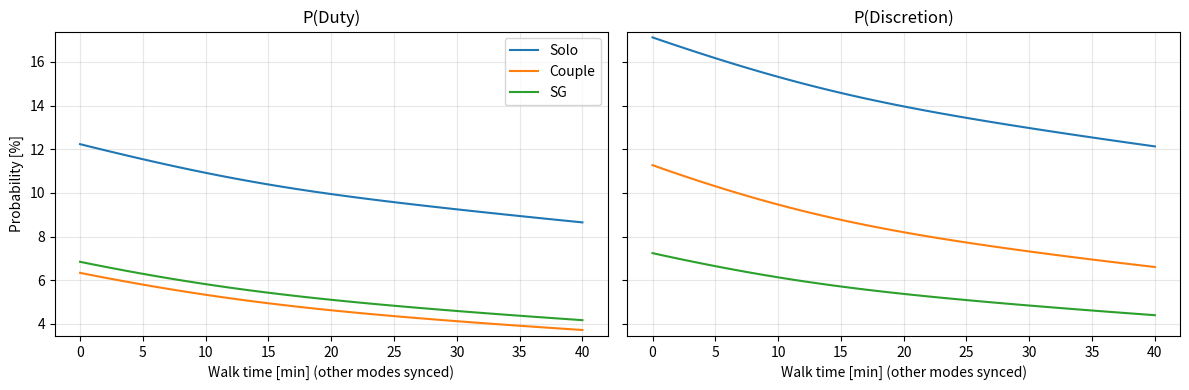

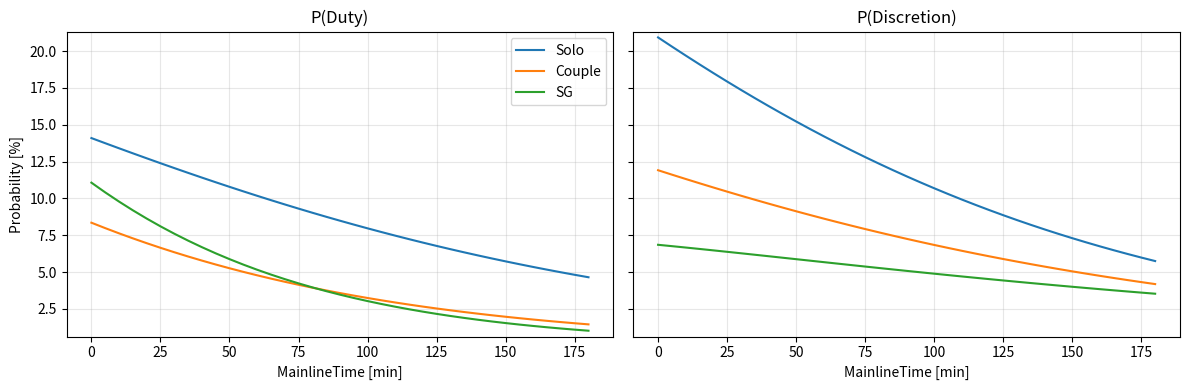

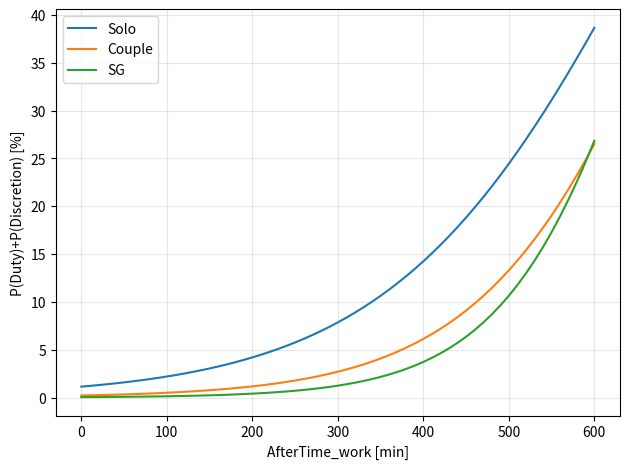

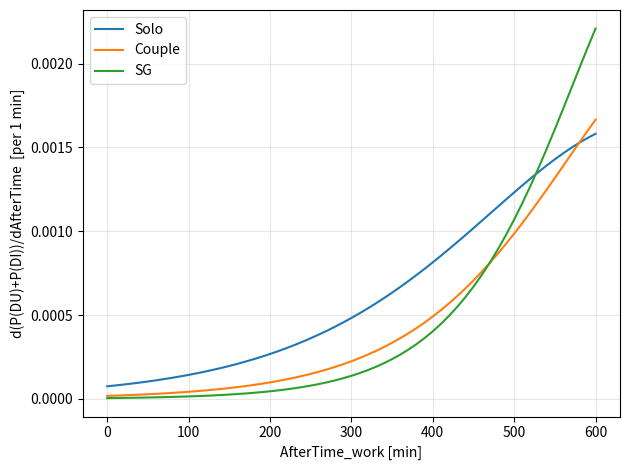

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# 0) 推定結果（get_beta_values）
# =========================================================
beta_solo   = solo_results.get_beta_values()
beta_couple = couple_results.get_beta_values()
beta_sg     = SG_results.get_beta_values()

betas = {
    "Solo": beta_solo,
    "Couple": beta_couple,
    "SG": beta_sg,
}

# =========================================================
# 1) 固定値（全体平均）
# =========================================================
AF0_h   = master_df["AfterTime_work[m]"].mean() / 60.0
MACM0_h = master_df["MainlineTime[m]"].mean() / 60.0
NEKI0   = master_df["near_1000index2"].mean() / 1_000_000

# 端末手段時間（各手段の平均）
WA0 = master_df["walk_time[m]"].mean()
BI0 = master_df["bicycle_time[m]"].mean()
BU0 = master_df["bus_time[m]"].mean()
CA0 = master_df["car_time[m]"].mean()

# 世帯構成別モデルなので HHM は区分ごと代表値（必要に応じて調整）
# ※ b_hhm_di は削除済みでも、b_hhm_du が残っていれば Duty 側にだけ効きます
HHM_by_segment = {"Solo": 1, "Couple": 2, "SG": 3}  # ★SGはあなたの定義に合わせて調整

# SGのみ child2 係数があるが、感度分析では child2=0固定
child2_by_segment = {"Solo": 0, "Couple": 0, "SG": 0}

# =========================================================
# 2) 数値安定化用
# =========================================================
def _logsumexp(a, axis=1):
    m = np.max(a, axis=axis, keepdims=True)
    return (m + np.log(np.sum(np.exp(a - m), axis=axis, keepdims=True))).squeeze()

def _softmax3(x0, x1, x2):
    X = np.column_stack([x0, x1, x2])
    m = np.max(X, axis=1, keepdims=True)
    E = np.exp(X - m)
    S = np.sum(E, axis=1, keepdims=True)
    P = E / S
    return P[:, 0], P[:, 1], P[:, 2]  # P_no, P_DU, P_DI

def _cond_probs(mu, V):
    Z = mu * V
    m = np.max(Z, axis=1, keepdims=True)
    E = np.exp(Z - m)
    S = np.sum(E, axis=1, keepdims=True)
    return E / S

# =========================================================
# 3) NLコア（P_no, P_DU, P_DI と内部量）
#    ★ b_hhm_di が無い場合でも動く（get(...,0)）
# =========================================================
def nl_core(beta, AF_h, MACM_h, NEKI, HHM, child2, WA, BI, BU, CA):
    AF_h = np.asarray(AF_h)
    MACM_h = np.asarray(MACM_h)
    N = AF_h.size

    # mode ASCs
    ASC_DU = beta["ASC_DU"]
    ASC_DI = beta["ASC_DI"]
    ASC_BI = beta.get("ASC_BI", 0.0)
    ASC_BU = beta.get("ASC_BU", 0.0)
    ASC_CA = beta.get("ASC_CA", 0.0)

    # coefficients
    b_at = beta["b_at"]
    b_af = beta["b_aftime_work"]

    b_mac_du = beta["b_macmtime_du"]
    b_n_du   = beta["b_n_eki_du"]
    b_hhm_du = beta.get("b_hhm_du", 0.0)     # あれば使う、無ければ0

    b_mac_di = beta["b_macmtime_di"]
    b_n_di   = beta["b_n_eki_di"]
    b_hhm_di = beta.get("b_hhm_di", 0.0)     # ★削除済み → 自動的に0

    # SGのみの可能性
    b_child2_du = beta.get("b_child2_du", 0.0)
    b_child2_di = beta.get("b_child2_di", 0.0)

    mu_du = 1.0 / beta["LAMBDA_DU"]
    mu_di = 1.0 / beta["LAMBDA_DI"]

    # purpose utilities
    V_DU_PRI = (
        ASC_DU
        + b_af * AF_h
        + b_mac_du * MACM_h
        + b_n_du * NEKI
        + b_hhm_du * HHM
        + b_child2_du * child2
    )
    V_DI_PRI = (
        ASC_DI
        + b_af * AF_h
        + b_mac_di * MACM_h
        + b_n_di * NEKI
        + b_hhm_di * HHM          # ★ほぼ0（係数削除なら0）
        + b_child2_di * child2
    )

    # mode utilities
    V_WA = b_at * WA
    V_BI = ASC_BI + b_at * BI
    V_BU = ASC_BU + b_at * BU
    V_CA = ASC_CA + b_at * CA

    # utilities within nests (N,4)
    V_du = np.column_stack([V_DU_PRI + V_WA, V_DU_PRI + V_BI, V_DU_PRI + V_BU, V_DU_PRI + V_CA])
    V_di = np.column_stack([V_DI_PRI + V_WA, V_DI_PRI + V_BI, V_DI_PRI + V_BU, V_DI_PRI + V_CA])

    # inclusive values
    IV_no = np.zeros(N)  # NoTrip: single alt utility=0
    IV_du = _logsumexp(mu_du * V_du, axis=1) / mu_du
    IV_di = _logsumexp(mu_di * V_di, axis=1) / mu_di

    P_no, P_DU, P_DI = _softmax3(IV_no, IV_du, IV_di)
    return P_no, P_DU, P_DI, V_du, V_di, mu_du, mu_di

# =========================================================
# 4-A) 最寄端末時間（徒歩時間を動かし、他モード時間を徒歩に連動）
#     → P(DU), P(DI)（限界効果も計算できるがここでは使わない）
# =========================================================
def access_time_PDUDI(beta, HHM, child2, WA_grid, sync="ratio"):
    WA = np.asarray(WA_grid)
    N = WA.size

    if sync == "ratio":
        eps = 1e-12
        r = WA / (WA0 + eps)
        BI = BI0 * r
        BU = BU0 * r
        CA = CA0 * r
    elif sync == "delta":
        d = WA - WA0
        BI = BI0 + d
        BU = BU0 + d
        CA = CA0 + d
    else:
        raise ValueError("sync must be 'ratio' or 'delta'")

    AF_h   = np.full(N, AF0_h)
    MACM_h = np.full(N, MACM0_h)

    P_no, P_DU, P_DI, *_ = nl_core(beta, AF_h, MACM_h, NEKI0, HHM, child2, WA, BI, BU, CA)
    return P_DU, P_DI

# =========================================================
# 4-B) 通勤メイン時間（MainlineTime[m]）→ P(DU), P(DI)
# =========================================================
def mainline_time_PDUDI(beta, HHM, child2, MACM_grid_min):
    MACM_min = np.asarray(MACM_grid_min)
    MACM_h = MACM_min / 60.0
    N = MACM_h.size

    AF_h = np.full(N, AF0_h)
    WA = np.full(N, WA0); BI = np.full(N, BI0); BU = np.full(N, BU0); CA = np.full(N, CA0)

    P_no, P_DU, P_DI, *_ = nl_core(beta, AF_h, MACM_h, NEKI0, HHM, child2, WA, BI, BU, CA)
    return P_DU, P_DI

# =========================================================
# 4-C) 退勤後時間（AfterTime_work[m]）→ Ptr=P(DU)+P(DI) と dPtr/dAfterTime
# =========================================================
def afterwork_time_Ptr(beta, HHM, child2, AF_grid_min):
    AF_min = np.asarray(AF_grid_min)
    AF_h = AF_min / 60.0
    N = AF_h.size

    MACM_h = np.full(N, MACM0_h)
    WA = np.full(N, WA0); BI = np.full(N, BI0); BU = np.full(N, BU0); CA = np.full(N, CA0)

    P_no, P_DU, P_DI, V_du, V_di, mu_du, mu_di = nl_core(beta, AF_h, MACM_h, NEKI0, HHM, child2, WA, BI, BU, CA)

    Ptr = P_DU + P_DI

    # AfterTime は DU/DI どちらにも同じ b_aftime_work（nest内一定）
    d = (beta["b_aftime_work"] / 60.0) * np.ones(N)
    dIV_no = np.zeros(N)
    dIV_du = d
    dIV_di = d

    avg = P_no*dIV_no + P_DU*dIV_du + P_DI*dIV_di
    dP_DU = P_DU * (dIV_du - avg)
    dP_DI = P_DI * (dIV_di - avg)

    dPtr = dP_DU + dP_DI
    return Ptr, dPtr

# =========================================================
# 5) 描画（要求：最寄端末＆メイン時間は横並び・縦軸揃え）
# =========================================================

# ---------- A) 最寄端末時間（徒歩時間）
WA_grid = np.arange(0.0, 40.0 + 0.5, 0.5)
sync_mode = "ratio"  # "ratio" or "delta"

curves = {}
y_all = []
for name, beta in betas.items():
    P_DU, P_DI = access_time_PDUDI(
        beta,
        HHM=HHM_by_segment[name],
        child2=child2_by_segment[name],
        WA_grid=WA_grid,
        sync=sync_mode,
    )
    curves[name] = (P_DU, P_DI)
    y_all.append(P_DU * 100)
    y_all.append(P_DI * 100)

y_all = np.concatenate(y_all)
ymin, ymax = float(np.min(y_all)), float(np.max(y_all))
pad = 0.02 * (ymax - ymin + 1e-12)
ylim = (ymin - pad, ymax + pad)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

ax = axes[0]
for name, (P_DU, P_DI) in curves.items():
    ax.plot(WA_grid, P_DU * 100, label=name)
ax.set_xlabel("Walk time [min] (other modes synced)")
ax.set_ylabel("Probability [%]")
ax.set_title("P(Duty)")
ax.set_ylim(*ylim)
ax.grid(True, alpha=0.3)
ax.legend()

ax = axes[1]
for name, (P_DU, P_DI) in curves.items():
    ax.plot(WA_grid, P_DI * 100, label=name)
ax.set_xlabel("Walk time [min] (other modes synced)")
ax.set_title("P(Discretion)")
ax.set_ylim(*ylim)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ---------- B) 通勤メイン時間
MACM_grid = np.arange(0.0, 180.0 + 5.0, 5.0)

curves = {}
y_all = []
for name, beta in betas.items():
    P_DU, P_DI = mainline_time_PDUDI(
        beta,
        HHM=HHM_by_segment[name],
        child2=child2_by_segment[name],
        MACM_grid_min=MACM_grid,
    )
    curves[name] = (P_DU, P_DI)
    y_all.append(P_DU * 100)
    y_all.append(P_DI * 100)

y_all = np.concatenate(y_all)
ymin, ymax = float(np.min(y_all)), float(np.max(y_all))
pad = 0.02 * (ymax - ymin + 1e-12)
ylim = (ymin - pad, ymax + pad)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

ax = axes[0]
for name, (P_DU, P_DI) in curves.items():
    ax.plot(MACM_grid, P_DU * 100, label=name)
ax.set_xlabel("MainlineTime [min]")
ax.set_ylabel("Probability [%]")
ax.set_title("P(Duty)")
ax.set_ylim(*ylim)
ax.grid(True, alpha=0.3)
ax.legend()

ax = axes[1]
for name, (P_DU, P_DI) in curves.items():
    ax.plot(MACM_grid, P_DI * 100, label=name)
ax.set_xlabel("MainlineTime [min]")
ax.set_title("P(Discretion)")
ax.set_ylim(*ylim)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ---------- C) 退勤後時間：Ptr と限界効果
AF_grid = np.arange(0.0, 600.0 + 10.0, 10.0)

# (1) Ptr = P(DU)+P(DI)
plt.figure()
for name, beta in betas.items():
    Ptr, dPtr = afterwork_time_Ptr(beta, HHM_by_segment[name], child2_by_segment[name], AF_grid)
    plt.plot(AF_grid, Ptr * 100, label=name)
plt.xlabel("AfterTime_work [min]")
plt.ylabel("P(Duty)+P(Discretion) [%]")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# (2) dPtr/dAfterTime
plt.figure()
for name, beta in betas.items():
    Ptr, dPtr = afterwork_time_Ptr(beta, HHM_by_segment[name], child2_by_segment[name], AF_grid)
    plt.plot(AF_grid, dPtr, label=name)
plt.xlabel("AfterTime_work [min]")
plt.ylabel("d(P(DU)+P(DI))/dAfterTime  [per 1 min]")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()